So uh, another Desmos Ballistic Calculator. Where do I start... https://www.desmos.com/calculator/az4angyumw

**Inputs:**
* `v_m` muzzle velocity [m/s]
* `h` height of target ABOVE cannon [m]
* `L` length of cannon [m]
* `X_R` target horizontal distance [m]


**How to use:**
* Input `X_R`

Read the red-black intersections, both high and low-angle solutions are there

"How would I use this in CC?"
- Precalculate all the constants
- Watch out for the square root
- Iterate from `t_0` to `t_n`*
- When you pass the target range, stop. Store `t - 0.5`,  return the corresponding angle
- If `X_R` decreases, stop. No solution.


*if target moves*
-  If movement is small, start from stored `t` and move up/down according to range delta or just iterate outward
- If target teleported, recalculate


*You can put any reasonable range here, but note that you should only solve for low-angle **or** high-angle, not at the same time. Starting from `t_0 = 0` means you'll always get the low-angle solution first.

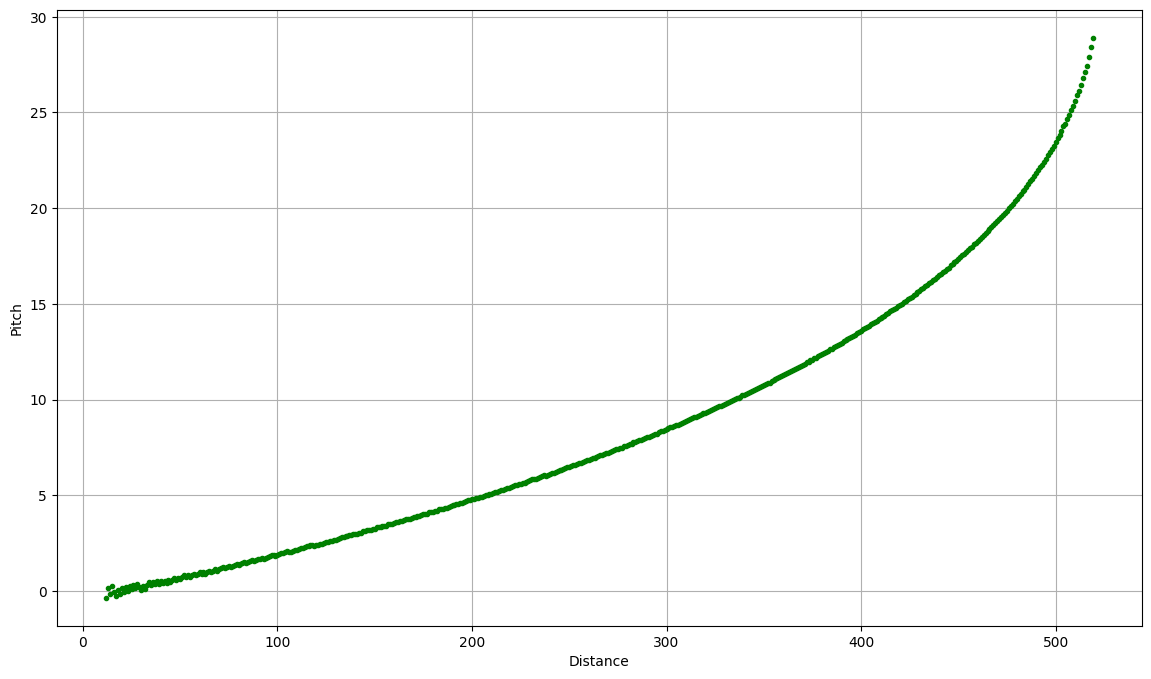

Simulated max range: (519, 28.9062710449924)


In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt


# TODO: allow for searching of the upper angle too!
def calculate_pitch_v2(
    distance,
    velocity_ms,
    target_height,
    cannon_length,
    t0=0,
    tn=750,
    start_step_size=18.75,
):
    # Constants:
    g = 0.05  # minecraft gravity
    c_d = 0.99  # drag coefficient

    # Inputs:
    X_R = distance
    v_m = velocity_ms
    h = target_height
    L = cannon_length

    start_step_size = start_step_size

    u = v_m / 20  # Convert to velocity per tick

    # Higher order parameters
    A = g * c_d / (u * (1 - c_d))
    B = lambda t: t * (g * c_d / (1 - c_d)) * 1 / X_R
    C = L / (u * X_R) * (g * c_d / (1 - c_d)) + h / X_R

    # The idea is to start with very large steps and decrease step size
    # the closer we get to the actual value.
    num_halvings = 10  # this is fine, too many halvings will slow down
    acceptable_threshold = 0.01  # how close to X_R is good enough

    def a_R(t):
        # "watch out for the square root" -endal
        B_t = B(t)
        in_root = -(A**2) + B_t**2 + C**2 + 2 * B_t * C + 1
        if in_root < 0:
            return None

        num_a_R = math.sqrt(in_root) - 1
        den_a_R = A + B_t + C
        return 2 * math.atan(num_a_R / den_a_R)

    # t = time projectile, either start from t0 and increment or tn and decrement
    t = t0
    increasing_t = True
    step_size = start_step_size
    for _ in range(num_halvings):
        while True:
            # It's taking too long, give up
            if t >= tn:
                return None, None

            # Angle of projectile
            a_R1 = a_R(t)
            if not a_R1:
                # a square root being negative means something
                # has gone wrong, so give up
                return None, None

            # Distance of projectile
            p1_X_R1 = u * math.cos(a_R1) / math.log(c_d)
            p2_X_R1 = c_d**t - 1
            p3_X_R1 = L * math.cos(a_R1)
            X_R1 = p1_X_R1 * p2_X_R1 + p3_X_R1

            # Good enough, let's call it quits
            if abs(X_R1 - X_R) <= acceptable_threshold:
                break

            # We're close to the target, now oscillate around the actual
            # target value until it's 'good enough' or it's taking too long.
            if increasing_t:
                if X_R1 > X_R:
                    increasing_t = False
                    break
                t += step_size
            else:
                if X_R1 < X_R:
                    increasing_t = True
                    break
                t -= step_size

        step_size /= 2

    return t, a_R1


# distance = 300
velocity_ms = 160
target_height = 0
cannon_length = 11
t0 = 0
tn = 750
start_step_size = 18.75

# t, pitch = calculate_pitch_v2(
#     distance=distance,
#     velocity_ms=velocity_ms,
#     target_height=target_height,
#     cannon_length=cannon_length,
#     t0=t0,
#     tn=tn,
#     start_step_size=start_step_size,
# )
# print(f"Flight time: {t} ticks, at {math.degrees(pitch) if pitch else None} degrees.")

distances_and_pitches = []
t = 0
for d in range(cannon_length + 1, 3000):
    t, pitch = calculate_pitch_v2(
        distance=d,
        velocity_ms=velocity_ms,
        target_height=target_height,
        cannon_length=cannon_length,
        t0=t,
        tn=tn,
        start_step_size=start_step_size,
    )

    if t == None or pitch == None:
        break

    distances_and_pitches.append((d, math.degrees(pitch)))

distances = [dp[0] for dp in distances_and_pitches]
pitches = [dp[1] for dp in distances_and_pitches]

plt.figure(figsize=(14, 8))
plt.plot(distances, pitches, marker=".", linestyle="", color="green")
plt.xlabel("Distance")
plt.ylabel("Pitch")
plt.grid(True)
plt.show()

# print(f"Simulated max range: {max(distances_and_pitches, key=lambda x: x[0])[0]}")
print(f"Simulated max range: {max(distances_and_pitches, key=lambda x: x[0])}")